# Image recognition with TensorFlow and Keras

In this notebook we will use computer vision, TensorFlow, and Keras for image classification and processing.
This tutorial is originated based on [Image recognition with TensorFlow and Keras tutorial](https://developer.ibm.com/technologies/vision/articles/image-recognition-challenge-with-tensorflow-and-keras-pt1/)
Using images, we will be able to classify whether a given image is a chihuahua (a dog breed) or a muffin.

The data set used with this article is formed by combining this [source](https://github.com/ieee8023/deep-learning-datasets/tree/master/chihuahua-muffin)and searching the internet and applying some basic image processing techniques. The images in this data set are collected, used, and provided under the Creative commons fair usage policy. The intended use is (for scientific research in image recognition using artificial neural networks) by using the TensorFlow and Keras library. This solution applies the same techniques as given in https://www.tensorflow.org/tutorials/keras/basic_classification

## Prerequisites

To complete the tutorial, you need an [IBM Cloud](https://cloud.ibm.com) account. You can [create a free account](http://ibm.biz/sacloud), which gives you access to IBM Cloud and [IBM Watson Studio](https://www.ibm.com/cloud/watson-studio).
You need to create a Watson Studio project and upload the images data into your assets. 

## Import TensorFlow, Keras, and other helper libraries

Start by installing the required libraries using pip. Then followed by importing these libraries. 
You will use TensorFlow and Keras for running the machine learning and the Pillow Python library for image processing.

Importing the Python libraries.

In [41]:
!pip install tensorflow matplotlib pillow --quiet

In [2]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import re

# Pillow
import PIL
from PIL import Image

## Import the data

A Python function to preprocess input images and convert them to grey scale.

Using colored image (like in RGB for instance) means that we have 3 dimensions, while grayscale has just one dimension. To avoid unnecessary cost in computation and since color has no significance in these images we will go ahead and convert images to gray scale.



In [15]:
# Use Pillow library to convert an input jpeg to a 8 bit grey scale image array for processing.
def jpeg_to_8_bit_greyscale(path, maxsize):
    img = Image.open(path).convert('L')   # convert image to 8-bit grayscale
    # Make aspect ratio as 1:1, by applying image crop.
    # Please note, croping works for this data set, but in general one
    # needs to locate the subject and then crop or scale accordingly.
    WIDTH, HEIGHT = img.size
    if WIDTH != HEIGHT:
        m_min_d = min(WIDTH, HEIGHT)
        img = img.crop((0, 0, m_min_d, m_min_d))
    
    # Scale the image to the requested maxsize by Anti-alias sampling.
    img.thumbnail(maxsize, PIL.Image.LANCZOS)
    
    return np.asarray(img)

A Python function to load the data set from images, into numpy arrays:

In [17]:
def load_image_dataset(path_dir, maxsize):
        images = []
        labels = []
        os.chdir(path_dir)
        for file in glob.glob("*.jpg"):
                img = jpeg_to_8_bit_greyscale(file, maxsize)
                if re.match('chihuahua.*', file):
                        images.append(img)
                        labels.append(0)
                elif re.match('muffin.*', file):
                        images.append(img)
                        labels.append(1)
        os.chdir("../")
        return (np.asarray(images), np.asarray(labels))


We should scale the images to some standard size smaller than actual image resolution. These images are more than 170×170, so we scale them all to 100×100 for further processing:

In [5]:
maxsize = 100, 100

From watson Studio layout, you will need to import the data. First make sure that your data is imported in your watson Studio project under data assets tab. Then select the following cell,open the data panel from 0100 icon in the upper right corner and choose your data. From Insert to code, select "Streamingbody object"

In [39]:
#From Data panel, select chihuahua-muffin_trainingset and select  insert to code Streamingbody object

Now you will need to unzip your training data.
Note: make sure that the variable name for streaming body (generated from previous cell) is the one used for unzipping. for example it is streaming_body_1

In [21]:
from io import BytesIO
import zipfile

zip_ref = zipfile.ZipFile(BytesIO(streaming_body_1.read()), 'r')
zip_ref.extractall()
zip_ref.close()

In [40]:
#From Data panel, select chihuahua-muffin_testset and select  insert to code Streamingbody object

You will also need to unzip your test data.
Note: make sure that the variable name for streaming body (generated from previous cell) is the one used for unzipping. for example it is streaming_body_2

In [23]:
zip_ref2 = zipfile.ZipFile(BytesIO(streaming_body_2.read()), 'r')
zip_ref2.extractall()
zip_ref2.close()

### Load the data

let uss execute the following functions and load training and test data sets:
train_images and train_lables is training data set.
test_images and test_labels is testing data set for validating the model’s performance against unseen data.


In [24]:
(train_images, train_labels) = load_image_dataset('chihuahua-muffin_trainingset', maxsize)
(test_images, test_labels) = load_image_dataset('chihuahua-muffin_testset', maxsize)

Now, we define the class names for our data set. Because this data has only two classes (an image can either be a Chihuahua or a Muffin), we have class_names as follows:

In [25]:
class_names = ['chihuahua', 'muffin']
train_images.shape

(26, 100, 100)

## Explore the data

In this data set, we have 26 training examples, of both Chihuahua and muffin images:

Each image has its respective label – either a 0 or 1. A 0 indicates a class_names[0] i.e. a chihuahua and 1 indicates class_names[1] i.e. a muffin:

In [26]:
print(train_labels)

[0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0]


For test set, we have 14 examples, seven for each class:

In [27]:
test_images.shape

(14, 100, 100)

In [28]:
print(test_labels)

[1 1 0 1 0 1 1 0 0 1 0 1 0 0]


## Visualize the data set

Using the matplotlib.pyplot Python library, we can visualize our data. Make sure you have the matplotlib library installed.

Following Python helper function helps us draw these images on our screen:

In [29]:
def display_images(images, labels):
        plt.figure(figsize=(10,10))
        grid_size = min(25, len(images))
        for i in range(grid_size):
                plt.subplot(5, 5, i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(images[i], cmap=plt.cm.binary)
                plt.xlabel(class_names[labels[i]])

Let’s visualize the training data set, as follows:
Note: The images are grayscaled and cropped in the preprocessing step of our images at the time of loading.

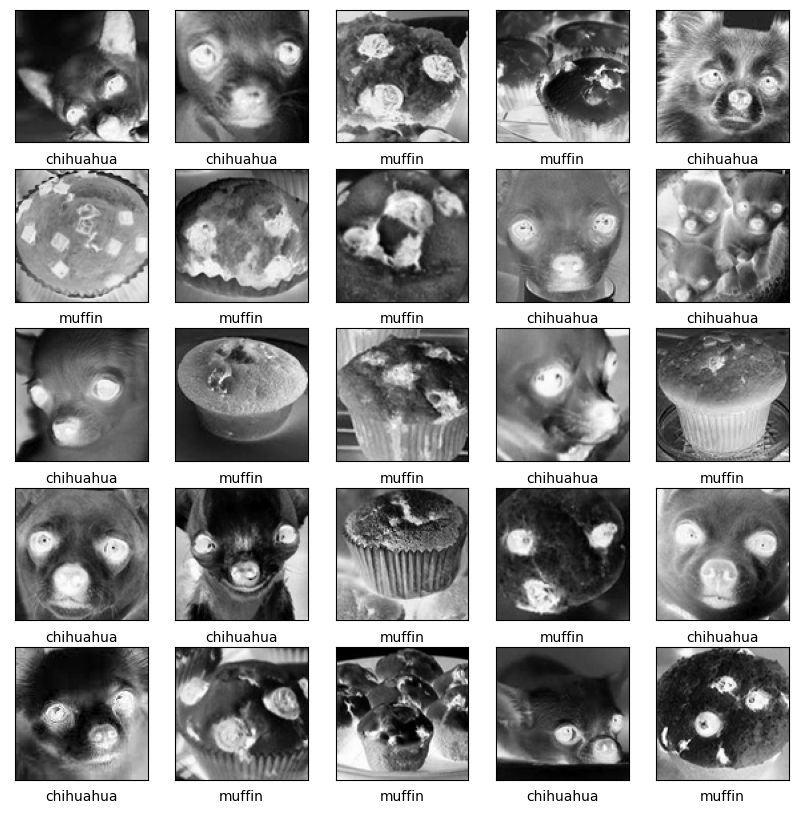

In [30]:
display_images(train_images, train_labels)
plt.show()

## Preprocess the data
Scaling the images to values between 0 and 1

In [31]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Build the model

Set up the layers, We have used four layers total. The first layer is to simply flatten the data set into a single array and does not get training. The other three layers are dense and use sigmoid as activation function:

In [32]:
# Setting up the layers.

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100)),
        keras.layers.Dense(128, activation=tf.nn.sigmoid),
        keras.layers.Dense(16, activation=tf.nn.sigmoid),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])


## Compile the model

The optimizer is stochastic gradient descent (SGD):

In [34]:
sgd = keras.optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True)

model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Train the model:
This may take some time, observe the changes in loss and accuracy.

In [35]:
model.fit(train_images, train_labels, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 621ms/step - loss: 0.8336 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 0.7836 - accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 0.7398 - accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 0.7106 - accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 0.6944 - accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6866 - accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6830 - accuracy: 0.5000
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 0.6813 - accuracy: 0.5769
Epoch 9/100
1/1 [==============================] - 0s 45ms/step - loss: 0.6802 - accuracy: 0.6538
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - loss: 0.6793 - accuracy: 0.6923
Epoch 11/100
1/1 [

## Evaluate accuracy
You may notice that test accuracy is less than training accuracy. This indicates model has overfit the data. 
With recent advances in image recognition and using more training data, we can perform much better on this data set challenge.

In [36]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

1/1 [==============================] - 0s 151ms/step - loss: 0.6437 - accuracy: 0.6429
Test accuracy: 0.6428571343421936


## Make predictions

To make predictions, we can simply call predict on the generated model:

In [37]:
predictions = model.predict(test_images)
print(predictions)

1/1 [==============================] - 0s 132ms/step
[[0.56400734 0.43599263]
 [0.515165   0.4848351 ]
 [0.5959105  0.40408948]
 [0.5332311  0.46676892]
 [0.6209549  0.3790452 ]
 [0.35298294 0.647017  ]
 [0.54344225 0.45655775]
 [0.6279338  0.37206617]
 [0.6130471  0.3869529 ]
 [0.4629864  0.5370136 ]
 [0.51090485 0.48909515]
 [0.6048761  0.39512393]
 [0.5055431  0.49445686]
 [0.5356995  0.4643005 ]]


Finally, display images and see how the model performed on test set:

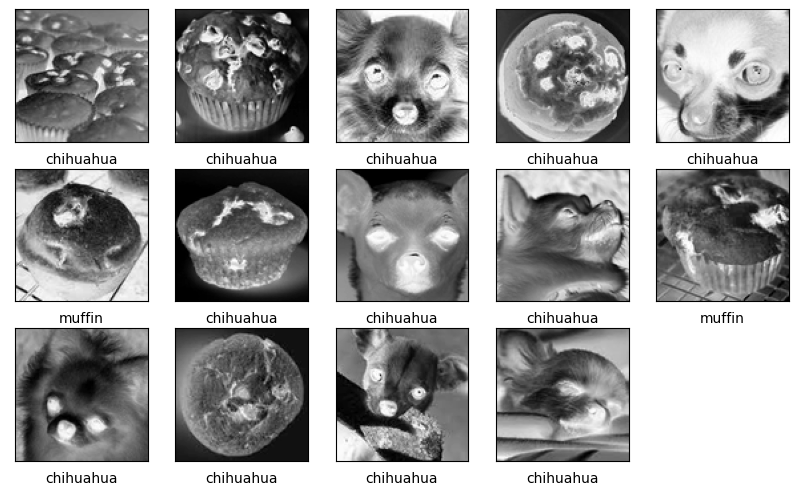

In [38]:
display_images(test_images, np.argmax(predictions, axis = 1))
plt.show()

## Conclusion

At this point you have learned how to train a neural network using Tensorflow and Keras. As you see there are a few wrong classifications in our result. Do you have ideas for how to enhance the model? If you want to learn more feel free to check methods of model enhancing in [part2](https://developer.ibm.com/articles/image-recognition-challenge-with-tensorflow-and-keras-pt2/) of this tutorial.